In [1]:
import numpy as np
import pandas as pd
import os
from fnmatch import fnmatch
import re
from datetime import datetime,timedelta

from bokeh.io import show , output_notebook
from bokeh.layouts import column, gridplot,layout
from bokeh.models import ColumnDataSource, RangeTool, HoverTool, TapTool, OpenURL,LinearColorMapper, CustomJS
from bokeh.plotting import figure
from bokeh.sampledata.stocks import AAPL
from bokeh.transform import factor_cmap
from bokeh.events import Tap
from bokeh.palettes import Spectral6,gray


output_notebook()

Loading BokehJS ...

In [2]:
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]



In [7]:
inputDir = r"data"

pattern_losses = "losses.npy"
pattern_lattents = "latent.npy"

all_losses = []
all_lattents = []

for path, subdirs, files in os.walk( os.path.join(".", inputDir), topdown=True):

    subdirs.sort(key=natural_keys)
    

    for name in files:
        
        if fnmatch(name, pattern_losses):    
            
            losses_curr = np.load(os.path.join(path, name))
            print(os.path.join(path, name)) 
            all_losses.append(losses_curr* 100000)
        
        if fnmatch(name, pattern_lattents):    
            
            lattents_curr = np.load(os.path.join(path, name),allow_pickle=True)
            all_lattents.extend(lattents_curr)



.\data\20210108\clip_0_1158\losses.npy
.\data\20210108\clip_1_1226\losses.npy
.\data\20210108\clip_2_1254\losses.npy
.\data\20210108\clip_3_1322\losses.npy
.\data\20210108\clip_4_1350\losses.npy
.\data\20210108\clip_5_1418\losses.npy
.\data\20210108\clip_6_1627\losses.npy
.\data\20210108\clip_7_1655\losses.npy
.\data\20210108\clip_8_1723\losses.npy
.\data\20210108\clip_9_1751\losses.npy
.\data\20210108\clip_10_1819\losses.npy
.\data\20210108\clip_11_1847\losses.npy
.\data\20210108\clip_12_1915\losses.npy
.\data\20210108\clip_13_1943\losses.npy
.\data\20210108\clip_14_2011\losses.npy
.\data\20210108\clip_15_2039\losses.npy
.\data\20210108\clip_16_2107\losses.npy
.\data\20210108\clip_17_2135\losses.npy
.\data\20210108\clip_18_2203\losses.npy
.\data\20210108\clip_19_2231\losses.npy
.\data\20210108\clip_20_2259\losses.npy
.\data\20210108\clip_21_2327\losses.npy
.\data\20210108\clip_22_2355\losses.npy
.\data\20210109\clip_0_0000\losses.npy
.\data\20210109\clip_1_0028\losses.npy
.\data\20210

In [11]:
print(len(all_losses))
print(len(all_lattents))

avg_losses =np.array([loss_arr.mean() for loss_arr in all_losses])
print(avg_losses.shape)

74
8954
(74,)


In [13]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


def pca_reduction(all_lattents, components):
    
    all_lattents_arr = np.array(all_lattents)
    print(all_lattents_arr.shape)
    
    pca_reduction = PCA(n_components=components)
    all_lattents_pca_reduced = pca_reduction.fit_transform(all_lattents_arr)
    
    variance = np.sum(pca_reduction.explained_variance_ratio_)
    print(f'Cumulative explained variation for {components} principal components:{variance}')
    
    return all_lattents_pca_reduced
    



def tsne_reduction(all_lattents):
    
    all_lattents_arr = np.array(all_lattents)
    print(all_lattents_arr.shape)

    
    pca_reduction = PCA(n_components=50)
    all_lattents_pca_reduced = pca_reduction.fit_transform(all_lattents_arr)
    print(f'Cumulative explained variation for 50 principal components:'.format(np.sum(pca_reduction.explained_variance_ratio_)))
    
    tsne_reduced = TSNE(learning_rate=50,n_jobs=-1, perplexity = 200).fit_transform(all_lattents_pca_reduced)
    
    
    return tsne_reduced
    



In [17]:
lattents_reduced = pca_reduction(all_lattents,2)

(8954, 2520)
Cumulative explained variation for 2 principal components:0.5041416883468628


In [18]:
reduced_lattents_df = pd.DataFrame(data = lattents_reduced
             , columns = ['principal component 1', 'principal component 2'])

reduced_lattents_df.head()

pca_fig = figure(plot_width=400, plot_height=400)

pca_fig.dot(reduced_lattents_df['principal component 1'], reduced_lattents_df['principal component 2'], size=20, color="navy", alpha=0.5)
show(pca_fig)

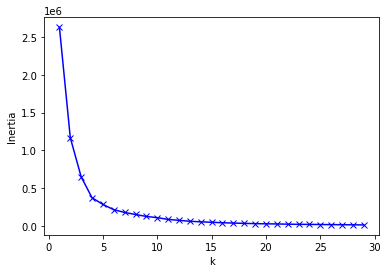

In [19]:
# TESTING KMEANS CLUSTERING

from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

inertia = []
K = range(1,30)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(reduced_lattents_df)
    kmeanModel.fit(reduced_lattents_df)
    inertia.append(kmeanModel.inertia_)
    
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()



In [20]:
kmeans = KMeans(n_clusters=6).fit(reduced_lattents_df)

labels = pd.DataFrame(kmeans.labels_)

reduced_lattents_df_labeled = pd.concat((reduced_lattents_df,labels),axis=1)
reduced_lattents_df_labeled = reduced_lattents_df_labeled.rename({0:'labels'},axis=1)

reduced_lattents_df_labeled.head()

,principal component 1,principal component 2,labels
0,9.788577,-8.652272,0
1,9.962327,-8.465648,0
2,9.629139,-8.263174,0
3,9.489848,-8.294386,0
4,9.603430,-8.201128,0


In [23]:
source = ColumnDataSource(data=reduced_lattents_df_labeled)

colors =  {0: "brown", 1: "green", 2: "blue", 3: "purple", 4: "red", 5: "yellow", 6:"black"}

reduced_lattents_df_labeled['labels_color'] = reduced_lattents_df_labeled['labels'].apply(lambda c: colors[c])

reduced_lattents_df_labeled.head()


knn_fig = figure(plot_width=400, plot_height=400)

knn_fig.circle(x ='principal component 1', y ='principal component 2', color = 'labels_color', source = source)
show(knn_fig)

In [36]:
metadataPath = r"data\metadata.csv"


metadata = pd.read_csv(metadataPath)
# Added dayfirst = True, because it did not work correctly
metadata['DateTime'] = pd.to_datetime(metadata['DateTime'], dayfirst = True)


metadata_expanded_losses = metadata.copy()

metadata['Losses'] = pd.Series(avg_losses).values

# for col in metadata.columns: 
#     print(col) 

metadata.head()

,Folder name,Clip Name,DateTime,Temperature,Humidity,Precipitation latest 10 min,Dew Point,Wind Direction,Wind Speed,Sun Radiation Intensity,Min of sunshine latest 10 min,Losses
0,20210108,clip_0_1158,2021-01-08 11:58:00,0.0,92,0.0,-1.2,13,2.5,39,0.0,345.950290
1,20210108,clip_1_1226,2021-01-08 12:26:00,0.0,92,0.0,-1.1,13,2.7,49,0.0,212.612645
2,20210108,clip_2_1254,2021-01-08 12:54:00,-0.1,93,0.0,-1.1,15,2.7,49,0.0,182.118553
3,20210108,clip_3_1322,2021-01-08 13:22:00,-0.1,93,0.0,-1.0,18,2.6,38,0.0,199.886032
4,20210108,clip_4_1350,2021-01-08 13:50:00,0.0,94,0.0,-1.0,14,2.5,15,0.0,165.287858


In [37]:
print(metadata_expanded_losses.shape)

metadata_expanded_losses['Losses'] = pd.Series(all_losses).values



lst_col = 'Losses'

metadata_expanded_losses = pd.DataFrame({
      col:np.repeat(metadata_expanded_losses[col].values, metadata_expanded_losses[lst_col].str.len())
      for col in metadata_expanded_losses.columns.drop(lst_col)}
    ).assign(**{lst_col:np.concatenate(metadata_expanded_losses[lst_col].values)})[metadata_expanded_losses.columns]


print(metadata_expanded_losses.shape)

(74, 11)
(8954, 12)


In [38]:
timeslots_times = np.array([0,3,6,9,12,15,18,21])

timeslots_coding = {
  1: "Early Post-Midnight",
  2: "Late Post-Midnight",
  3: "Early Morning",
  4: "Late Morning",
  5: "Early Afternoon",
  6: "Late Afternoon",
  7: "Early Evening",
  8: "Late Evening",
}

weekdays_coding = {
  0: "Monday",
  1: "Tuesday",
  2: "Wednesday",
  3: "Thursday",
  4: "Friday",
  5: "Saturday",
  6: "Sunday"
}



curr_timeslots = np.searchsorted(timeslots_times, metadata_expanded_losses.iloc[:,2].dt.hour, side='right')


metadata_expanded_losses['Timeslot'] = curr_timeslots

metadata_expanded_losses['Weekday'] = metadata_expanded_losses.iloc[:,2].dt.weekday

metadata_expanded_losses['T-sne PC1'] = reduced_lattents_df['principal component 1']

metadata_expanded_losses['T-sne PC2'] = reduced_lattents_df['principal component 2']

In [39]:
metadata_expanded_losses.head()

,Folder name,Clip Name,DateTime,Temperature,Humidity,Precipitation latest 10 min,Dew Point,Wind Direction,Wind Speed,Sun Radiation Intensity,Min of sunshine latest 10 min,Losses,Timeslot,Weekday,T-sne PC1,T-sne PC2
0,20210108,clip_0_1158,2021-01-08 11:58:00,0.0,92,0.0,-1.2,13,2.5,39,0.0,345.938304,4,4,9.788577,-8.652272
1,20210108,clip_0_1158,2021-01-08 11:58:00,0.0,92,0.0,-1.2,13,2.5,39,0.0,349.312602,4,4,9.962327,-8.465648
2,20210108,clip_0_1158,2021-01-08 11:58:00,0.0,92,0.0,-1.2,13,2.5,39,0.0,355.110923,4,4,9.629139,-8.263174
3,20210108,clip_0_1158,2021-01-08 11:58:00,0.0,92,0.0,-1.2,13,2.5,39,0.0,354.707870,4,4,9.489848,-8.294386
4,20210108,clip_0_1158,2021-01-08 11:58:00,0.0,92,0.0,-1.2,13,2.5,39,0.0,360.194198,4,4,9.603430,-8.201128


In [43]:


colors =  {0: "brown", 1: "green", 2: "blue", 3: "purple", 4: "red", 5: "yellow", 6:"black", 7:"cyan", 8:"orange"}

metadata_expanded_losses['labels_color_weekday'] = metadata_expanded_losses['Weekday'].apply(lambda c: colors[c])

metadata_expanded_losses['labels_name_weekday'] = list(map(weekdays_coding.get, metadata_expanded_losses['Weekday']))

# metadata_expanded_losses['labels_color_timeslot'] = metadata_expanded_losses['Timeslot'].apply(lambda c: colors[c])

# metadata_expanded_losses['labels_name_timeslot'] = list(map(weekdays_coding.get, metadata_expanded_losses['Timeslot']))

metadata_expanded_losses.head()




,Folder name,Clip Name,DateTime,Temperature,Humidity,Precipitation latest 10 min,Dew Point,Wind Direction,Wind Speed,Sun Radiation Intensity,Min of sunshine latest 10 min,Losses,Timeslot,Weekday,T-sne PC1,T-sne PC2,labels_color_weekday,labels_name_weekday
0,20210108,clip_0_1158,2021-01-08 11:58:00,0.0,92,0.0,-1.2,13,2.5,39,0.0,345.938304,4,4,9.788577,-8.652272,red,Friday
1,20210108,clip_0_1158,2021-01-08 11:58:00,0.0,92,0.0,-1.2,13,2.5,39,0.0,349.312602,4,4,9.962327,-8.465648,red,Friday
2,20210108,clip_0_1158,2021-01-08 11:58:00,0.0,92,0.0,-1.2,13,2.5,39,0.0,355.110923,4,4,9.629139,-8.263174,red,Friday
3,20210108,clip_0_1158,2021-01-08 11:58:00,0.0,92,0.0,-1.2,13,2.5,39,0.0,354.707870,4,4,9.489848,-8.294386,red,Friday
4,20210108,clip_0_1158,2021-01-08 11:58:00,0.0,92,0.0,-1.2,13,2.5,39,0.0,360.194198,4,4,9.603430,-8.201128,red,Friday


In [44]:
source = ColumnDataSource(data=metadata_expanded_losses)

knn_fig = figure(plot_width=800, plot_height=800)

knn_fig.circle(x ='T-sne PC1', y ='T-sne PC2', color = 'labels_color_weekday',legend_group='labels_name_weekday', source = source)

knn_fig.legend.location = "top_left"
knn_fig.legend.click_policy="hide"
show(knn_fig)

In [54]:
all_figs = []

source = ColumnDataSource(data=metadata)

x_range = []

for col in metadata.columns: 


    if col not in ["Folder name", "Clip Name", "DateTime"]:
        
        if not x_range:
            x_range = [metadata['DateTime'][0], metadata['DateTime'][50]]
            
        else:
            x_range = p.x_range
            
        
        
        p = figure(plot_height=300, plot_width=450, tools="xpan", toolbar_location=None,
           x_axis_type="datetime", x_axis_location="above",
           background_fill_color="#efefef", x_range=x_range)
        p.line("DateTime", col, source=source)
        p.yaxis.axis_label = col
        
        all_figs.append(p)
    

select = figure(title="Drag the middle and edges of the selection box to change the range above",
                plot_height=130, plot_width=900,
                x_axis_type="datetime", y_axis_type=None,
                tools="", toolbar_location=None, background_fill_color="#efefef")

range_tool = RangeTool(x_range=all_figs[0].x_range)
range_tool.overlay.fill_color = "green"
range_tool.overlay.fill_alpha = 0.2

select.line("DateTime", "DateTime", source=source)
select.ygrid.grid_line_color = None
select.add_tools(range_tool)
select.toolbar.active_multi = range_tool
select.yaxis.axis_label = "DateTime"

In [55]:
weather_plots = gridplot(all_figs, ncols=2)

full_layout = layout([
    weather_plots,
    select
])

show(full_layout)